# 1) Data upload

In [67]:
if(!require(remotes)) install.packages("readr")
library (readr)

github="https://raw.githubusercontent.com/agronomy4future/raw_data_practice/main/sulphur%20application.csv"
df=data.frame(read_csv(url(github),show_col_types = FALSE))
print(head(df,3))

  variety sulphur yield
1     CV1   20.67  1286
2     CV1   19.90  1165
3     CV1   19.73  1176


In [68]:
variety= rep(c("CV1","CV2","CV3","CV4","CV5"), each=9)
sulphur= c(20.67, 19.9, 19.73,21.16, 21.61, 20.9, 22.36, 21.97, 21.9, 21.34, 21.28,
           21.9, 20.7, 22.65, 22.16, 22.03, 20.4, 22.47, 22.65, 21.82, 24.41, 22.34,
           24.03, 24.38, 23.6, 23.44, 23.51, 23.89, 24.7, 22.8, 23.08, 25.05, 24.09,
           24.3, 25.23, 23.14, 24.06, 26.98, 25.71, 23.93, 25.16, 23.79, 26.34, 24.64,
           24.77)
yield= c(1286, 1165, 1176, 1262, 1271, 1221, 1374, 1288, 1285, 1261, 1281, 1302, 1199,
         1368, 1340, 1272, 1276, 1329, 1361, 1267, 1380, 1386, 1408, 1380, 1378, 1413,
         1400, 1412, 1422, 1381, 1410, 1410, 1381, 1422, 1389, 1403, 1420, 1403, 1400,
         1420, 1379, 1393, 1417, 1415, 1383)
df= data.frame(variety,sulphur,yield)
print(head(df,3))

  variety sulphur yield
1     CV1   20.67  1286
2     CV1   19.90  1165
3     CV1   19.73  1176


#2) Quadratic regression model

In [69]:
regression= lm(yield ~ poly(sulphur,2, raw=TRUE), data=df)
summary(regression)


Call:
lm(formula = yield ~ poly(sulphur, 2, raw = TRUE), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-51.536 -23.671   1.901  17.072  60.441 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -3707.735    643.594  -5.761 8.76e-07 ***
poly(sulphur, 2, raw = TRUE)1   403.477     55.829   7.227 6.90e-09 ***
poly(sulphur, 2, raw = TRUE)2    -7.948      1.206  -6.588 5.67e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.53 on 42 degrees of freedom
Multiple R-squared:  0.8637,	Adjusted R-squared:  0.8572 
F-statistic: 133.1 on 2 and 42 DF,  p-value: < 2.2e-16


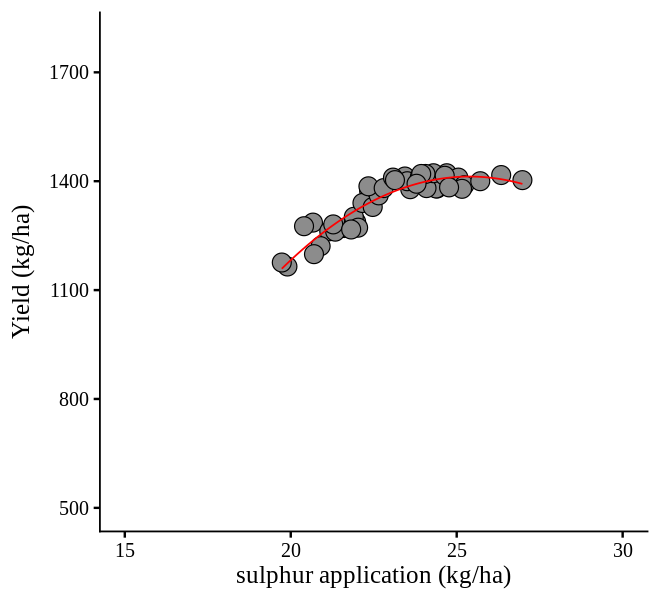

In [70]:
Fig1= ggplot(data=df, aes(x=sulphur, y=yield)) +
  geom_point(aes(shape=variety, fill=variety),col="black", size=5, stroke = 0.5) +
  geom_smooth(method=lm, level=0.95, se=FALSE, linetype=1, size=0.5, color="Red",
              formula=y~poly(x,2, raw=TRUE)) +
  scale_shape_manual(values=rep(c(21),5)) +
  scale_fill_manual(values=rep(c("grey55"),5))+
  scale_x_continuous(breaks=seq(15,30,5), limits=c(15,30)) +
  scale_y_continuous(breaks=seq(500,1800,300), limits=c(500,1800)) +
  labs(x="sulphur application (kg/ha)", y="Yield (kg/ha)") +
  theme_classic(base_size=15, base_family="serif")+
  theme(legend.position="none",
        axis.line=element_line(linewidth=0.5, colour="black"))

options(repr.plot.width=5.5, repr.plot.height=5)
print(Fig1)

ggsave("Fig1.png", plot= Fig1, width=5.5, height= 5, dpi= 300)

#3) Quadratic plateau model

##3.1) to find reasonable initial values for parameters

In [71]:
fit.lm= lm(yield ~ poly(sulphur,2, raw=TRUE),data=df)
a_parameter= fit.lm$coefficients[1]
b_parameter= fit.lm$coefficients[2]
c_parameter= fit.lm$coefficients[3]
x_mean= mean(df$sulphur)

In [72]:
a_parameter

(Intercept) 
  -3707.735

In [73]:
b_parameter

poly(sulphur, 2, raw = TRUE)1 
                     403.4771

In [74]:
c_parameter

poly(sulphur, 2, raw = TRUE)2 
                       -7.948

In [75]:
x_mean

[1] 23.04378

## 3.2) to define quadratic plateau function

In [76]:
# a = intercept
# b = slope
# c = quadratic term (curvy bit)
# jp = join point = break point

qp= function(x, a, b, jp) {
  c= -0.5 * b / jp
  ifelse(x < jp,
          a + (b * x) + (c * x * x),
          a + (b * jp) + (c * jp * jp))
}

## 3.3) to find the best fit parameters

Method 1

In [77]:
if(!require(dplyr)) install.packages("dplyr")
library(dplyr)

model1= nls(formula=yield ~ qp(sulphur, a, b, jp),
           data=df,
           start=list(a=a_parameter, b=b_parameter, jp=x_mean))

summary(model1)


Formula: yield ~ qp(sulphur, a, b, jp)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
a  -4174.2608   923.9016  -4.518 5.01e-05 ***
b    445.3539    81.5181   5.463 2.34e-06 ***
jp    25.0656     0.4925  50.897  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.33 on 42 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 5.685e-06


Method 2

In [78]:
quadratic= lm(yield~poly(sulphur,2,raw= TRUE), data= df)
parameter= coef(quadratic)

model2= nls(formula=yield~qp(sulphur, a, b, jp),
            data=df,
            start=list(a=parameter[1],
                       b=parameter[2],
                       jp=mean(df$sulphur)))

summary(model2)


Formula: yield ~ qp(sulphur, a, b, jp)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
a  -4174.2608   923.9016  -4.518 5.01e-05 ***
b    445.3539    81.5181   5.463 2.34e-06 ***
jp    25.0656     0.4925  50.897  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.33 on 42 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 5.685e-06


Method 3

In [79]:
if(!require(minpack.lm)) install.packages("minpack.lm")
library(minpack.lm)

model3= nlsLM(formula=yield~qp(sulphur, a, b, jp),
            data=df,
            start=list(a=a_parameter,
                       b=b_parameter,
                       jp=x_mean))

summary(model3)


Formula: yield ~ qp(sulphur, a, b, jp)

Parameters:
                                  Estimate Std. Error t value Pr(>|t|)    
a.(Intercept)                   -4174.1798   923.8905  -4.518 5.01e-05 ***
b.poly(sulphur, 2, raw = TRUE)1   445.3466    81.5171   5.463 2.34e-06 ***
jp                                 25.0657     0.4925  50.896  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.33 on 42 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 1.49e-08


Method 4

In [80]:
if(!require(nlraa)) install.packages("nlraa")
library(nlraa)

model4= nlsLM(formula=yield~SSquadp3xs(sulphur,a,b,jp),
       data=df)

summary(model4)


Formula: yield ~ SSquadp3xs(sulphur, a, b, jp)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
a  -4174.1127   923.8811  -4.518 5.01e-05 ***
b    445.3407    81.5162   5.463 2.34e-06 ***
jp    25.0657     0.4925  50.896  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.33 on 42 degrees of freedom

Number of iterations to convergence: 7 
Achieved convergence tolerance: 1.49e-08


## 3.4) Visualization

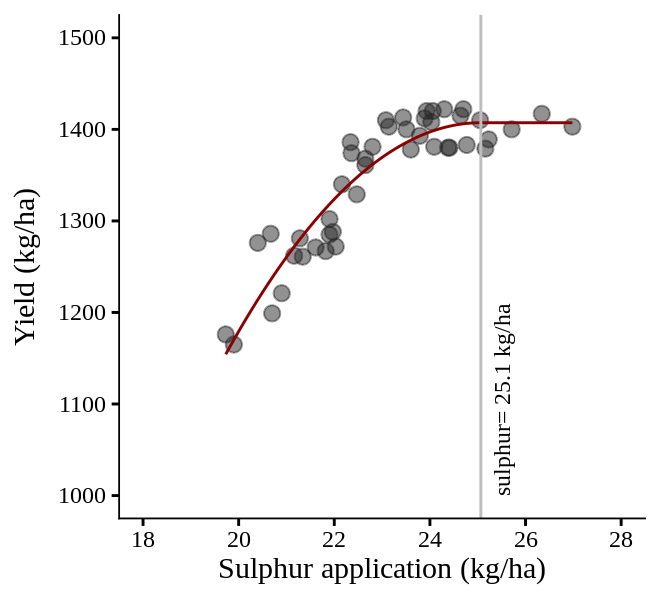

In [81]:
if(!require(ggplot2)) install.packages("ggplot2")
if(!require(minpack.lm)) install.packages("minpack.lm")
if(!require(nlraa)) install.packages("nlraa")
library(ggplot2)
library(minpack.lm)
library(nlraa)

Fig2= df %>%
  ggplot(aes(sulphur, yield)) +
  geom_point(size=4, alpha = 0.5, color="grey15") +
  geom_line(stat="smooth",
            method="nls",
            formula=y ~ SSquadp3xs(x, a, b, jp),
            se=FALSE,
            color="darkred") +

  geom_vline(xintercept=25.0656, linetype="solid", color="grey") +
  annotate("text", label=paste("sulphur=","25.1","kg/ha"),
           x=25.2, y=1000, angle=90, hjust=0, vjust=1.5, size=5)+

  scale_x_continuous(breaks = seq(18,28,2), limits = c(18,28)) +
  scale_y_continuous(breaks = seq(1000,1500,100), limits = c(1000,1500)) +
  labs(x="Sulphur application (kg/ha)", y="Yield (kg/ha)") +
  theme_classic (base_size=18, base_family="serif")+
  theme(legend.position="none",
        axis.line=element_line(linewidth=0.5, colour="black"))

options(repr.plot.width=5.5, repr.plot.height=5)
print(Fig2)

ggsave("Fig2.png", plot= Fig2, width=5.5, height= 5, dpi= 300)

#4) p-value and pseudo R-squared

In [82]:
nullfunct= function(x, m){m}
m.ini= mean(df$yield)
null= nls(yield~nullfunct(sulphur, m),
          data=df,
          start=list(m=m.ini),
          trace=FALSE,
          nls.control(maxiter= 1000))

In [83]:
if(!require(rcompanion)) install.packages("rcompanion")
library(rcompanion)
print(nagelkerke(model1, null))

$Models
                                                                                                                                                                           
Model: "nls, yield ~ qp(sulphur, a, b, jp), df, list(a = a_parameter, b = b_parameter, jp = x_mean), default, list(50, 1e-05, 0.0009765625, FALSE, FALSE, 0, FALSE), FALSE"
Null:  "nls, yield ~ nullfunct(sulphur, m), df, list(m = m.ini), list(1000, 1e-05, 0.0009765625, FALSE, FALSE, 0, FALSE), FALSE, default"                                  

$Pseudo.R.squared.for.model.vs.null
                             Pseudo.R.squared
McFadden                             0.176208
Cox and Snell (ML)                   0.865660
Nagelkerke (Cragg and Uhler)         0.865670

$Likelihood.ratio.test
 Df.diff LogLik.diff  Chisq    p.value
      -2     -45.166 90.332 2.4244e-20

$Number.of.observations
         
Model: 45
Null:  45

$Messages
[1] "Note: For models fit with REML, these statistics are based on refitting with ML"



# ■ Full code

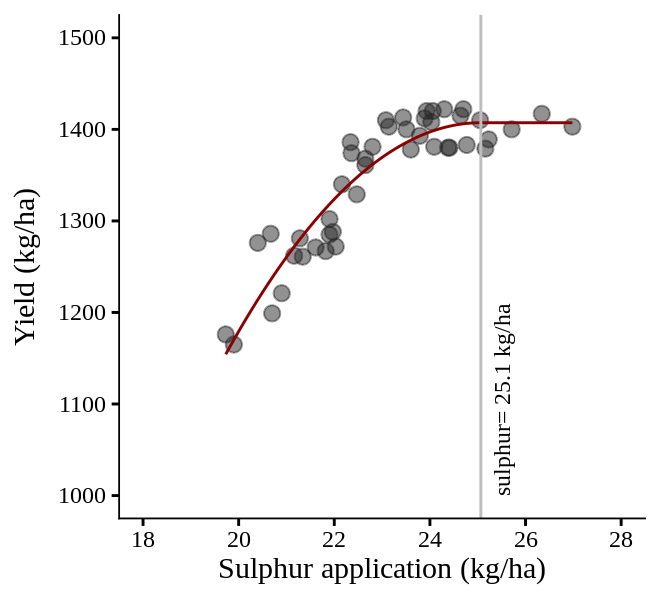

In [85]:
if(!require(remotes)) install.packages("readr")
if(!require(ggplot2)) install.packages("ggplot2")
if(!require(minpack.lm)) install.packages("minpack.lm")
if(!require(nlraa)) install.packages("nlraa")
library (readr)
library(ggplot2)
library(minpack.lm)
library(nlraa)


github="https://raw.githubusercontent.com/agronomy4future/raw_data_practice/main/sulphur%20application.csv"
df=data.frame(read_csv(url(github),show_col_types = FALSE))

fit.lm= lm(yield ~ poly(sulphur,2, raw=TRUE),data=df)
a_parameter= fit.lm$coefficients[1]
b_parameter= fit.lm$coefficients[2]
c_parameter= fit.lm$coefficients[3]
x_mean= mean(df$sulphur)

qp= function(x, a, b, jp) {
  c= -0.5 * b / jp
  ifelse(x < jp,
          a + (b * x) + (c * x * x),
          a + (b * jp) + (c * jp * jp))
}

quadratic= lm(yield~poly(sulphur,2,raw= TRUE), data= df)
parameter= coef(quadratic)

model2= nls(formula=yield~qp(sulphur, a, b, jp),
            data=df,
            start=list(a=parameter[1],
                       b=parameter[2],
                       jp=mean(df$sulphur)))

Fig2= df %>%
  ggplot(aes(sulphur, yield)) +
  geom_point(size=4, alpha = 0.5, color="grey15") +
  geom_line(stat="smooth",
            method="nls",
            formula=y ~ SSquadp3xs(x, a, b, jp),
            se=FALSE,
            color="darkred") +

  geom_vline(xintercept=25.0656, linetype="solid", color="grey") +
  annotate("text", label=paste("sulphur=","25.1","kg/ha"),
           x=25.2, y=1000, angle=90, hjust=0, vjust=1.5, size=5)+

  scale_x_continuous(breaks = seq(18,28,2), limits = c(18,28)) +
  scale_y_continuous(breaks = seq(1000,1500,100), limits = c(1000,1500)) +
  labs(x="Sulphur application (kg/ha)", y="Yield (kg/ha)") +
  theme_classic (base_size=18, base_family="serif")+
  theme(legend.position="none",
        axis.line=element_line(linewidth=0.5, colour="black"))

options(repr.plot.width=5.5, repr.plot.height=5)
print(Fig2)

ggsave("Fig2.png", plot= Fig2, width=5.5, height= 5, dpi= 300)
